# Dog Breed Identification

Determine the breed of a dog in an image.  
https://www.kaggle.com/competitions/dog-breed-identification

# Prepare Data

In [1]:
!pip install fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 5.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.8 MB/s eta 0:00:00


Download data with: `kaggle competitions download -c dog-breed-identification`

- `-q` (quiet) - suppress the file names but still see errors
- `-d` - an optional directory to which to extract files

In [2]:
!unzip -q /datasets/dogs/dog-breed-identification.zip -d /notebooks/dogs/

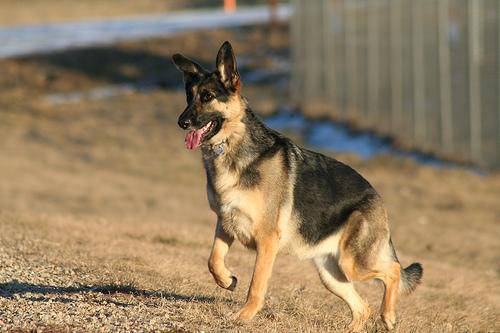

In [2]:
from IPython.display import Image, display
display(Image(filename='/notebooks/dogs/train/a9a4ef737174d6169ea7be588f6c71be.jpg'))

In [3]:
import pandas as pd
from fastai.vision.all import *

from datetime import datetime

In [4]:
labels = pd.read_csv("/notebooks/dogs/labels.csv")
num_pics = len(labels)
unique_breeds = labels["breed"].unique()

print(f"There are {num_pics} labeled files.")
print(f"Unique breeds ({len(unique_breeds)}): {unique_breeds}")
print(labels.head())

There are 10222 labeled files.
Unique breeds (120): ['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier'
 'kuvasz' 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 'm

In [5]:
def get_breed(path):
    """
    Given a file path, this function extracts the breed of the animal from the 'labels' dataframe.

    Parameters:
    path (Path): A file path object, typically pointing to an image file.

    Returns:
    str: The breed of the animal corresponding to the ID extracted from the file name.

    The function performs the following steps:
    1. Extracts the file name from the given path and splits it to get the ID part.
    2. Matches this ID with the 'id' column in the 'labels' dataframe.
    3. Retrieves the corresponding breed from the 'breed' column in the 'labels' dataframe.
    4. Returns the breed as a string.

    Note: It assumes the 'labels' dataframe is already defined and available in the scope, 
    with 'id' and 'breed' as its columns. The file name is expected to have the ID as the second last 
    component when split by dots ('.').
    """
    return labels[labels["id"] == str(path.name).split(".")[-2]].iloc[0]["breed"]

In [6]:
dogs = DataBlock(
    # The first argument, ImageBlock, serves as an independent variable, 
    # while the second, CategoryBlock, functions as a dependent variable.
    blocks=(ImageBlock, CategoryBlock), 
    # `get_items` is used to specify how to obtain the raw items or data points for the dataset.
    # `get_image_files` is a library function for loading images.
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1),
    get_y=get_breed,
    # Data Augmentation
    # 
    # 0.5 scale is really close and helps to show individual features of a dog.
    # 224x224 is the default size for many pre-trained models, including ResNet50,
    # and often works well for most tasks.
    item_tfms=RandomResizedCrop(244, min_scale=0.5),
    # mult - Multiplication applying to max_rotate, max_lighting, max_warp. The default is 1.
    batch_tfms=aug_transforms(mult=2)
)

In [7]:
# Default batch size (bs) is 64. Works wells with 244x244 and 16G of GPU memory.
dls = dogs.dataloaders("/notebooks/dogs/train")

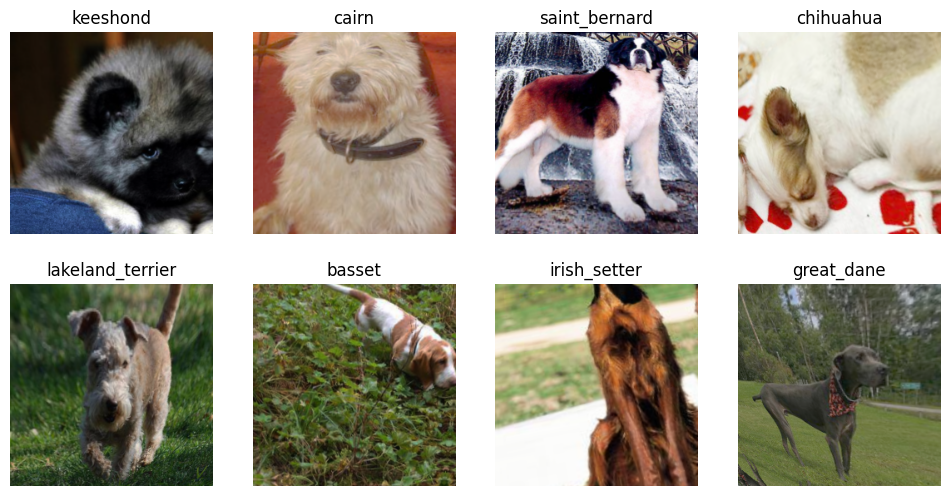

In [9]:
dls.train.show_batch(max_n=8, nrows=2, unique=False)

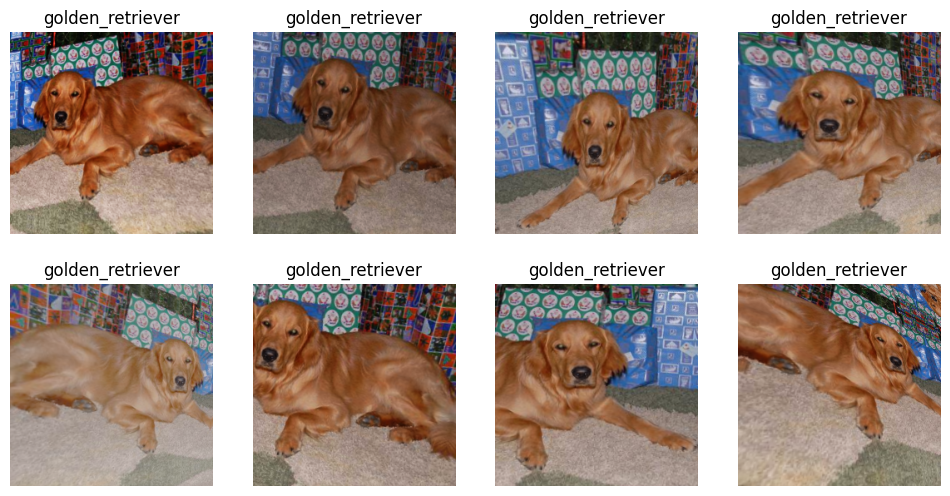

In [10]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Train a Model

In [8]:
from fastai.callback.tracker import EarlyStoppingCallback

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.3MB/s]


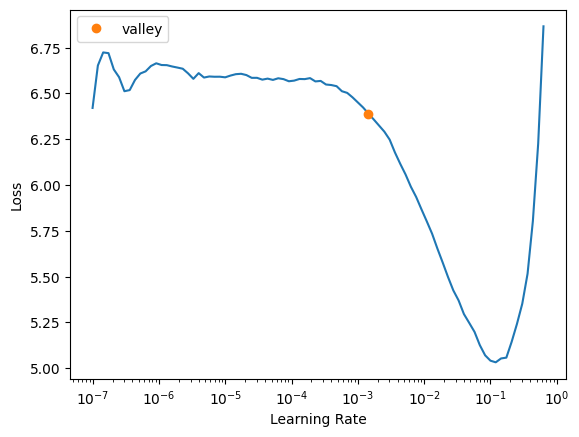

In [9]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.freeze()

# Find an optimal learning rate
learn.lr_find()
learn.fine_tune(5, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

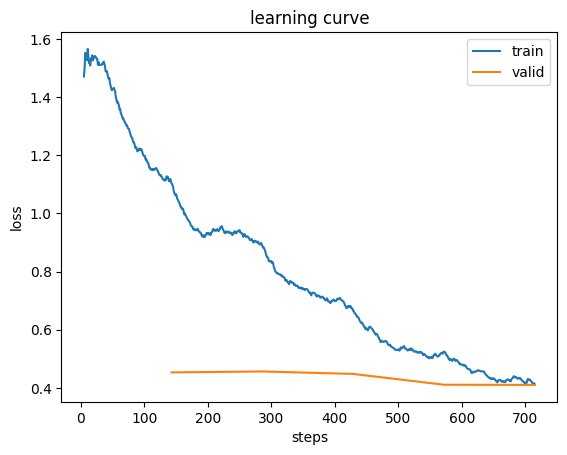

In [10]:
learn.recorder.plot_loss()

Unfortunately, the common computer vision practice of unfreezing the model and fine-tuning all layers didn't work out. Instead, I'll use the output from the frozen fine-tuned version.

In [11]:
#learn.unfreeze()
#learn.lr_find()
#learn.fine_tune(15)

# Predict

In [17]:
from fastai.learner import load_learner

learn = load_learner('export_20240625_142909_0_118.pkl')
labels = learn.dls.vocab

In [9]:
def predict_breed(img):
    predicted_class, predicted_idx, probabilities = learn.predict(f'{img}')
    probability_dict = {label: f"{prob.item():.17f}" for label, prob in zip(labels, probabilities)}
    return predicted_class, probability_dict

In [10]:
# prediction example
predicted_class, probability_dict = predict_breed('dogs/test/002c58d413a521ae8d1a5daeb35fc803.jpg')
predicted_class, probability_dict

('samoyed',
 {'affenpinscher': '0.00000018341994235',
  'afghan_hound': '0.00000057807505982',
  'african_hunting_dog': '0.00000002990963210',
  'airedale': '0.00000000803374878',
  'american_staffordshire_terrier': '0.00000001520486670',
  'appenzeller': '0.00000003005517257',
  'australian_terrier': '0.00000016316289475',
  'basenji': '0.00000014334254672',
  'basset': '0.00000002323338855',
  'beagle': '0.00000002655787057',
  'bedlington_terrier': '0.00000002163212010',
  'bernese_mountain_dog': '0.00000011064091154',
  'black-and-tan_coonhound': '0.00000000205830819',
  'blenheim_spaniel': '0.00000005994139229',
  'bloodhound': '0.00000000696144031',
  'bluetick': '0.00000001615049428',
  'border_collie': '0.00000155420468673',
  'border_terrier': '0.00000000850642756',
  'borzoi': '0.00000006414124698',
  'boston_bull': '0.00000001049322229',
  'bouvier_des_flandres': '0.00000040632414766',
  'boxer': '0.00000010840059161',
  'brabancon_griffon': '0.00000000563122748',
  'briard'

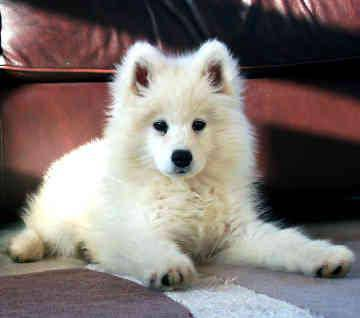

In [13]:
display(Image(filename='/notebooks/dogs/test/002c58d413a521ae8d1a5daeb35fc803.jpg'))

The competition's grading system requires a CSV file formatted with image IDs in each row and breeds in each column, where every cell contains a numerical probability that an image belongs to a particular breed.

In [14]:
test_files = [f"/notebooks/dogs/test/{f}" for f in os.listdir("dogs/test/") if os.path.isfile(os.path.join("/notebooks/dogs/test/", f))]
test_dl = learner.dls.test_dl(test_files)

Instead of looping over all images, it's more efficient to make predictions in batches. Although I haven't examined the internal implementation of batch processing, I've observed that this function takes advantage of multiple CPUs.

In [ ]:
preds, _ = learner.get_preds(dl=test_dl)

In [19]:
preds_array = preds.numpy()
df = pd.DataFrame(preds_array, columns=learn.dls.vocab)
df.insert(0, 'filename', test_files)

In [20]:
df

filename  \
0      /notebooks/dogs/test/7a10aa1b0b3e1215524c03e1928dabd0.jpg   
1      /notebooks/dogs/test/c34aade3107de7d049c56c9d90f9d0b6.jpg   
2      /notebooks/dogs/test/73fbb8ed8dbff26e9ccd31f60733f93e.jpg   
3      /notebooks/dogs/test/d08c477d0d6b6060163c61f030699bb3.jpg   
4      /notebooks/dogs/test/b20476845f34b078cf3f631b9e0e02f9.jpg   
...                                                          ...   
10352  /notebooks/dogs/test/4554879208d1548e22501876808242e5.jpg   
10353  /notebooks/dogs/test/8d243d285e72a16d8c266866f5e6738e.jpg   
10354  /notebooks/dogs/test/1c7539843a19526dbdb4bfbc24bb45b2.jpg   
10355  /notebooks/dogs/test/a7e0132c587509077161318621932a04.jpg   
10356  /notebooks/dogs/test/bbcc0c2a73db3d332e94406397f7748e.jpg   

       affenpinscher  afghan_hound  african_hunting_dog      airedale  \
0       2.245594e-07  7.491715e-08         6.269671e-08  8.773622e-07   
1       2.662467e-06  4.074260e-06         7.494505e-06  2.901727e-08   
2       4.052501e-07  8.501068e-08         1.595723e-08  2.218311e-06   
3       1.696637e-06  2.229843e-06         7.560757e-07  5.439949e-05   
4       3.384450e-08  5.028533e-08         6.367372e-09  2.629990e-09   
...              ...           ...                  ...           ...   
10352   2.315239e-05  1.254311e-04         1.119880e-05  1.614365e-03   
10353   3.123379e-08  8.167995e-07         1.893533e-06  6.236779e-06   
10354   1.402004e-10  1.159408e-07         2.206323e-09  2.264918e-08   
10355   2.640163e-08  2.133465e-09         8.013247e-10  1.402578e-09   
10356   2.201097e-05  7.200405e-07         1.972496e-06  2.978404e-07   

       american_staffordshire_terrier   appenzeller  australian_terrier  \
0                        9.148246e-08  1.851984e-07        7.809563e-09   
1                        5.737486e-08  6.170870e-08        5.741073e-07   
2                        1.923305e-06  4.032437e-08        1.225385e-07   
3                        6.526715e-06  9.388638e-07        3.097573e-06   
4                        5.536426e-10  2.070394e-10        2.112166e-08   
...                               ...           ...                 ...   
10352                    3.203751e-04  2.639153e-02        5.163724e-05   
10353                    6.648441e-07  2.936206e-06        4.877826e-07   
10354                    3.071701e-09  2.841970e-09        1.313016e-08   
10355                    2.933215e-09  3.775992e-08        2.237937e-10   
10356                    2.567205e-07  7.845011e-08        1.286967e-07   

            basenji        basset  ...    toy_poodle   toy_terrier  \
0      2.985500e-08  6.848505e-08  ...  2.635400e-07  6.221940e-07   
1      1.485952e-07  1.597700e-07  ...  1.488797e-06  4.842047e-08   
2      5.511101e-07  7.078024e-08  ...  2.212916e-08  6.884650e-08   
3      3.516151e-06  8.286081e-04  ...  2.913895e-05  4.799390e-06   
4      8.118915e-09  6.866477e-09  ...  3.989507e-08  3.462481e-09   
...             ...           ...  ...           ...           ...   
10352  1.309691e-04  1.645346e-03  ...  1.202138e-05  8.495185e-04   
10353  5.252198e-07  6.404053e-08  ...  6.362330e-08  1.090622e-06   
10354  1.245535e-09  2.590207e-08  ...  4.633148e-09  6.138740e-10   
10355  9.620799e-09  2.386840e-09  ...  6.413722e-10  4.685668e-06   
10356  6.881108e-07  8.062160e-08  ...  5.567012e-08  4.589232e-08   

             vizsla  walker_hound    weimaraner  welsh_springer_spaniel  \
0      3.004364e-07  1.273864e-07  2.384058e-06            2.100158e-07   
1      6.884730e-07  8.317889e-08  1.196328e-06            4.143228e-07   
2      9.998379e-01  6.588930e-08  7.758406e-07            7.113822e-08   
3      8.955802e-06  8.507827e-05  1.596219e-06            7.720587e-01   
4      7.400609e-09  3.842924e-09  1.200113e-07            2.036579e-09   
...             ...           ...           ...                     ...   
10352  2.114160e-04  3.520051e-03  6.161302e-05            1.553726e-05   
10353  2.194176e-07 

In [22]:
df['filename'] = df['filename'].apply(lambda x: str(os.path.basename(x)).split(".")[0])
df.rename(columns={'filename': 'id'}, inplace=True)

In [23]:
df

id  affenpinscher  afghan_hound  \
0      7a10aa1b0b3e1215524c03e1928dabd0   2.245594e-07  7.491715e-08   
1      c34aade3107de7d049c56c9d90f9d0b6   2.662467e-06  4.074260e-06   
2      73fbb8ed8dbff26e9ccd31f60733f93e   4.052501e-07  8.501068e-08   
3      d08c477d0d6b6060163c61f030699bb3   1.696637e-06  2.229843e-06   
4      b20476845f34b078cf3f631b9e0e02f9   3.384450e-08  5.028533e-08   
...                                 ...            ...           ...   
10352  4554879208d1548e22501876808242e5   2.315239e-05  1.254311e-04   
10353  8d243d285e72a16d8c266866f5e6738e   3.123379e-08  8.167995e-07   
10354  1c7539843a19526dbdb4bfbc24bb45b2   1.402004e-10  1.159408e-07   
10355  a7e0132c587509077161318621932a04   2.640163e-08  2.133465e-09   
10356  bbcc0c2a73db3d332e94406397f7748e   2.201097e-05  7.200405e-07   

       african_hunting_dog      airedale  american_staffordshire_terrier  \
0             6.269671e-08  8.773622e-07                    9.148246e-08   
1             7.494505e-06  2.901727e-08                    5.737486e-08   
2             1.595723e-08  2.218311e-06                    1.923305e-06   
3             7.560757e-07  5.439949e-05                    6.526715e-06   
4             6.367372e-09  2.629990e-09                    5.536426e-10   
...                    ...           ...                             ...   
10352         1.119880e-05  1.614365e-03                    3.203751e-04   
10353         1.893533e-06  6.236779e-06                    6.648441e-07   
10354         2.206323e-09  2.264918e-08                    3.071701e-09   
10355         8.013247e-10  1.402578e-09                    2.933215e-09   
10356         1.972496e-06  2.978404e-07                    2.567205e-07   

        appenzeller  australian_terrier       basenji        basset  ...  \
0      1.851984e-07        7.809563e-09  2.985500e-08  6.848505e-08  ...   
1      6.170870e-08        5.741073e-07  1.485952e-07  1.597700e-07  ...   
2      4.032437e-08        1.225385e-07  5.511101e-07  7.078024e-08  ...   
3      9.388638e-07        3.097573e-06  3.516151e-06  8.286081e-04  ...   
4      2.070394e-10        2.112166e-08  8.118915e-09  6.866477e-09  ...   
...             ...                 ...           ...           ...  ...   
10352  2.639153e-02        5.163724e-05  1.309691e-04  1.645346e-03  ...   
10353  2.936206e-06        4.877826e-07  5.252198e-07  6.404053e-08  ...   
10354  2.841970e-09        1.313016e-08  1.245535e-09  2.590207e-08  ...   
10355  3.775992e-08        2.237937e-10  9.620799e-09  2.386840e-09  ...   
10356  7.845011e-08        1.286967e-07  6.881108e-07  8.062160e-08  ...   

         toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0      2.635400e-07  6.221940e-07  3.004364e-07  1.273864e-07  2.384058e-06   
1      1.488797e-06  4.842047e-08  6.884730e-07  8.317889e-08  1.196328e-06   
2      2.212916e-08  6.884650e-08  9.998379e-01  6.588930e-08  7.758406e-07   
3      2.913895e-05  4.799390e-06  8.955802e-06  8.507827e-05  1.596219e-06   
4      3.989507e-08  3.462481e-09  7.400609e-09  3.842924e-09  1.200113e-07   
...             ...           ...           ...           ...           ...   
10352  1.202138e-05  8.495185e-04  2.114160e-04  3.520051e-03  6.161302e-05   
10353  6.362330e-08  1.090622e-06  2.194176e-07  4.342012e-07  7.109439e-08   
10354  4.633148e-09  6.138740e-10  2.525604e-09  3.137905e-09  1.030975e-09   
10355  6.413722e-10  4.685668e-06  2.243620e-08  1.046273e-09  8.766064e-07   
10356  5.567012e-08  4.589232e-08  7.138483e-08  4.369639e-08  2.474812e-07   

       welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0                2.100158e-07                 5.316652e-07  1.853034e-06   
1                4.143228e-07                 1.131093e-07  5.664955e-08   
2                7.113822e-08                 5.786255e-08  1.523435e-06   
3                7.720587e-01                 2.535401e-06  4.817255e-06   
4                

In [24]:
# The output result I upload to Kaggle.
df.to_csv('predictions.csv', index=False, float_format='%.17f')

The model achieved a private/public score of **0.39899**, placing it roughly in the middle of the leaderboard.

# Data Analysis

In [15]:
# let's see whether the mistakes the model is making
interp = ClassificationInterpretation.from_learner(learn)

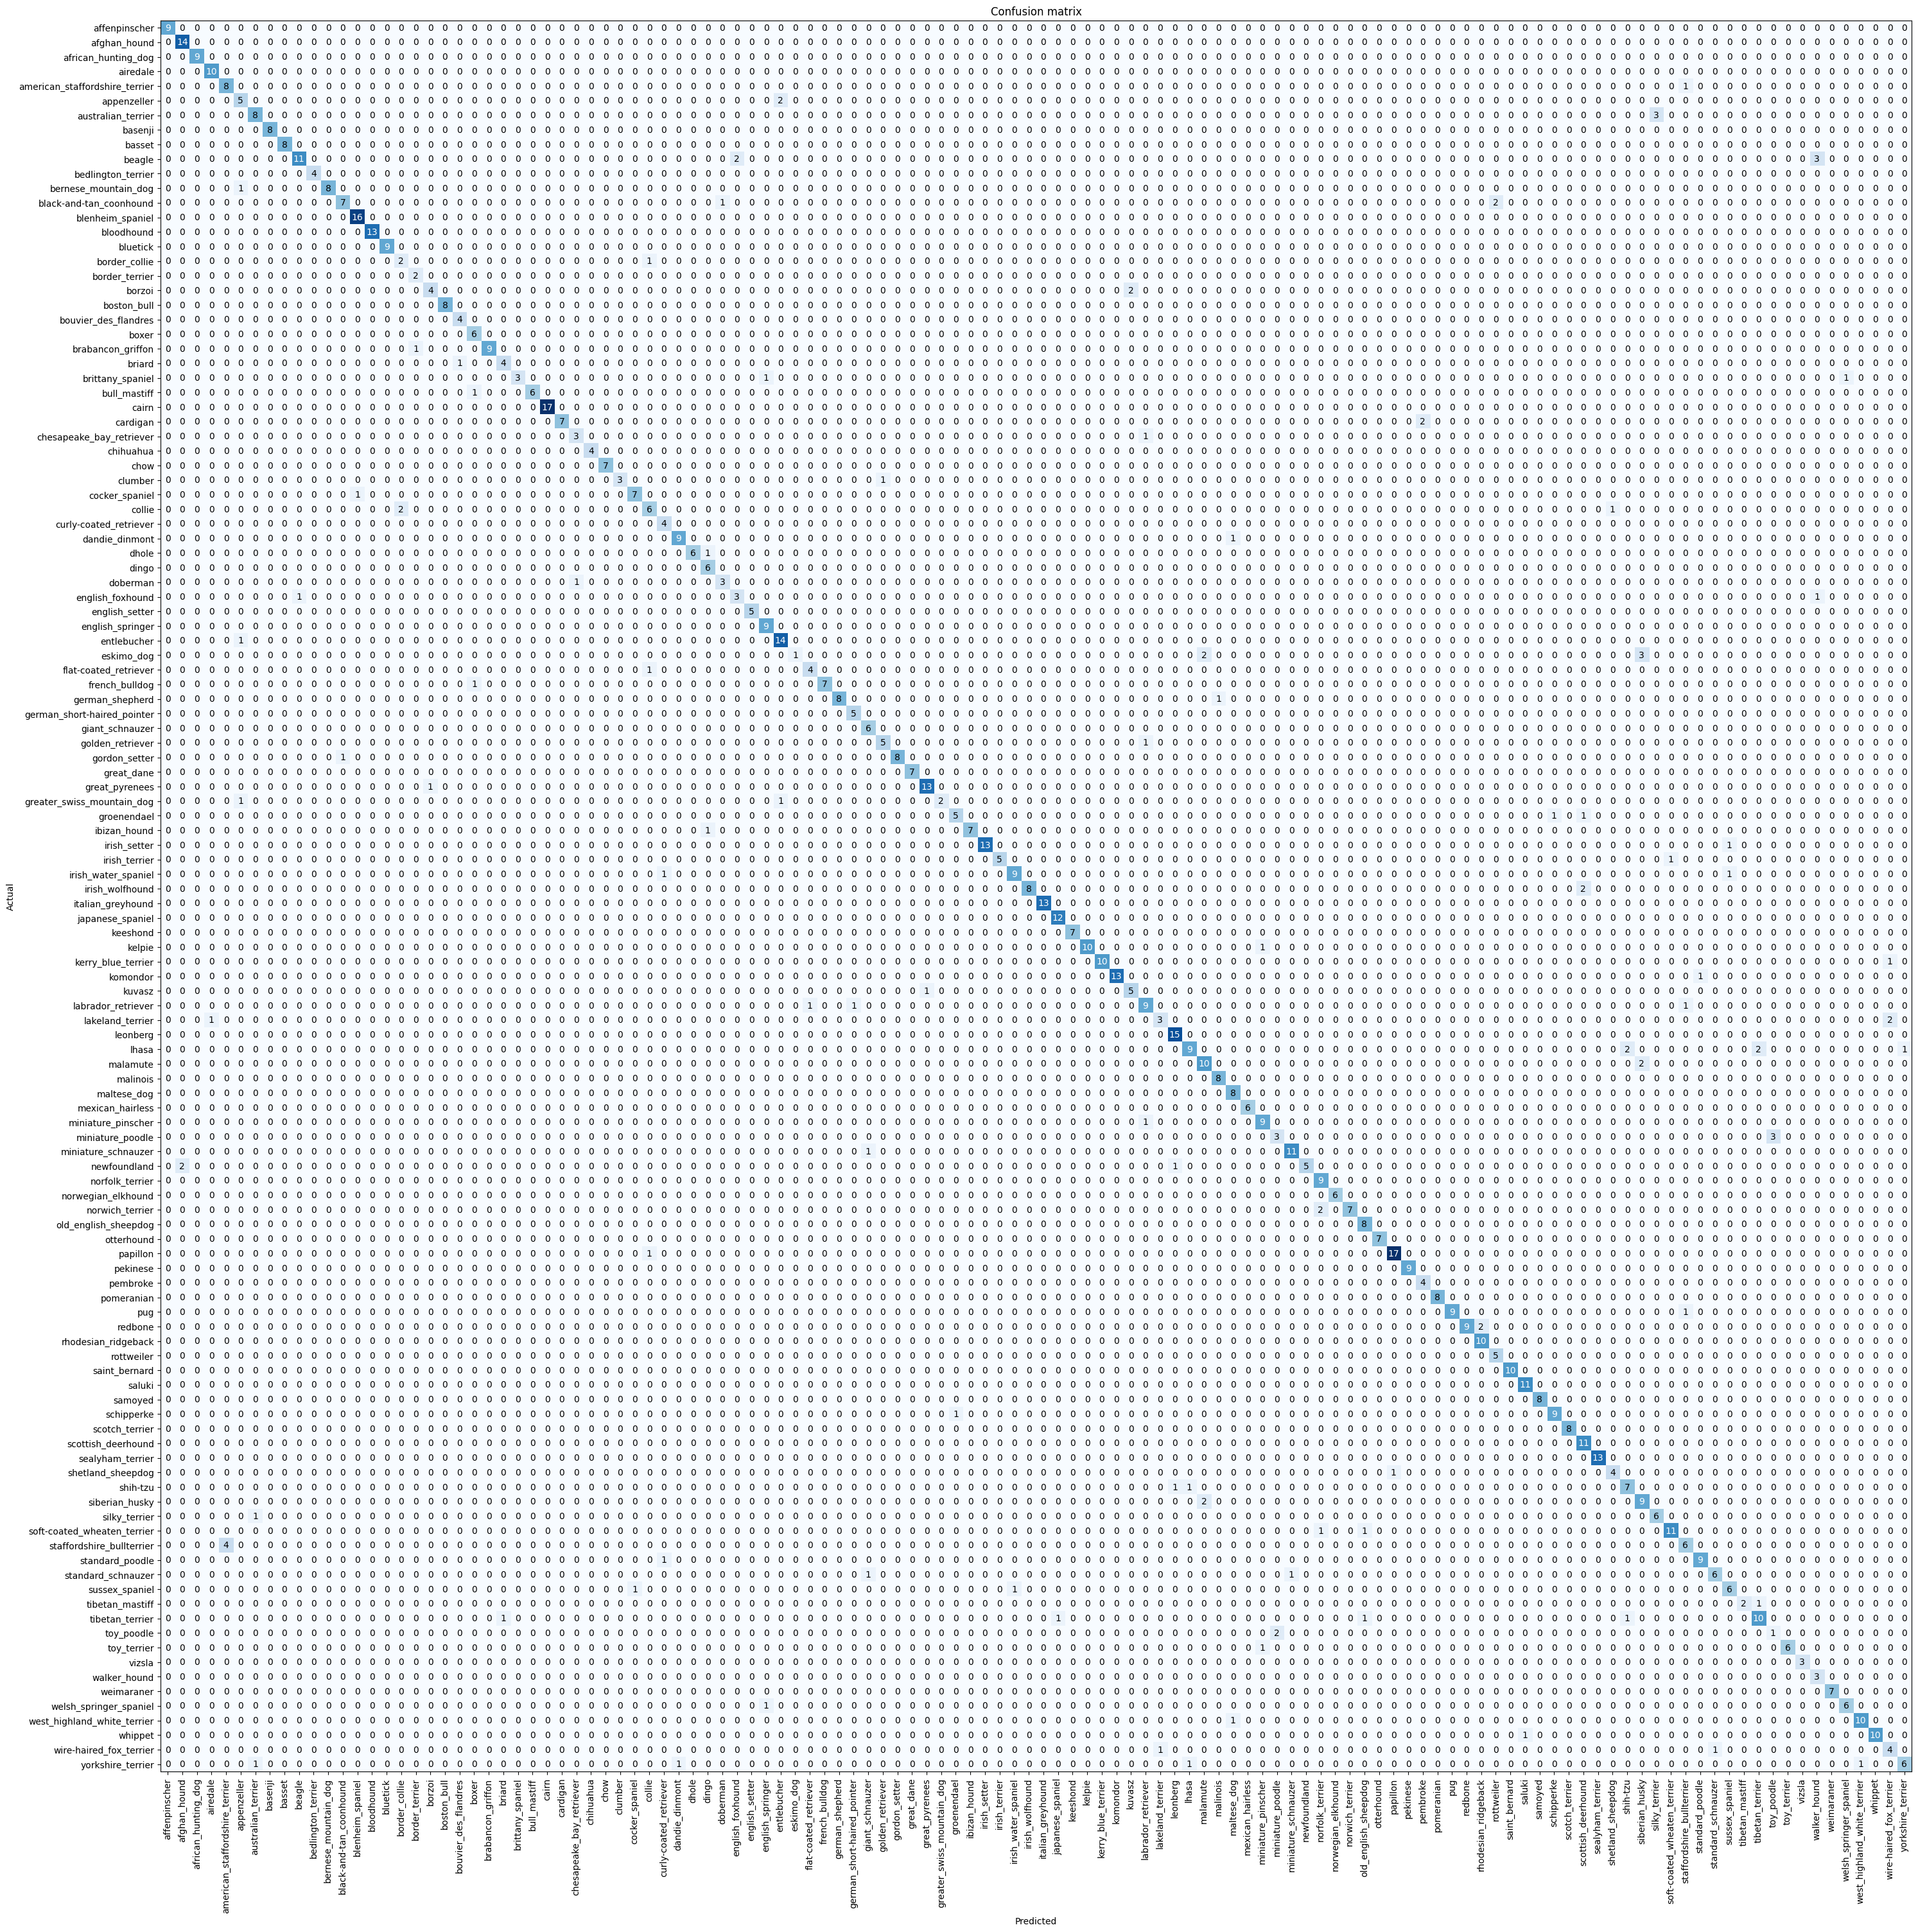

In [16]:
interp.plot_confusion_matrix(figsize=(30,30))

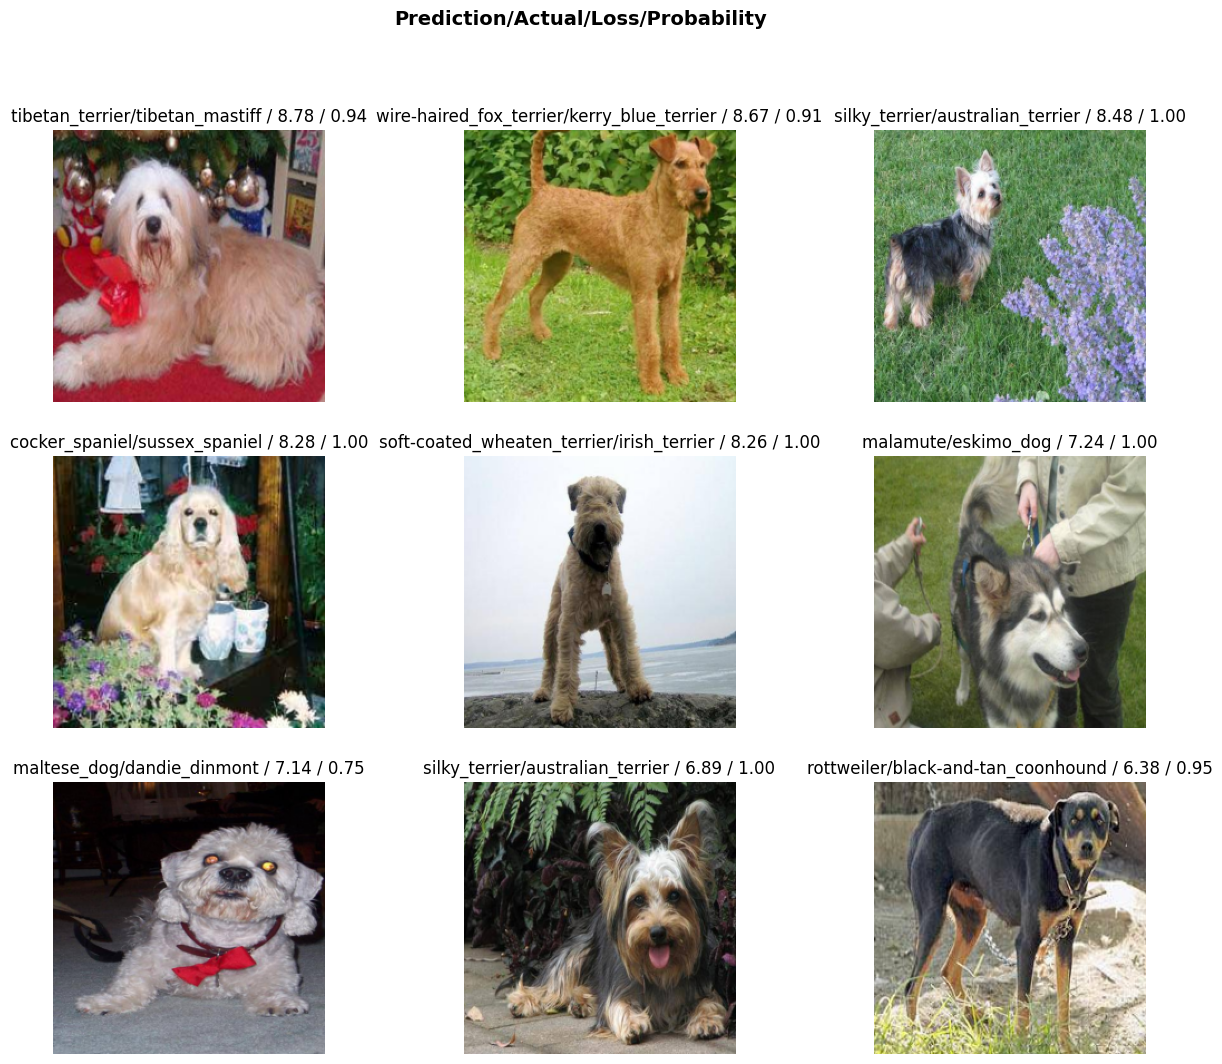

In [21]:
interp.plot_top_losses(9, nrows=3, figsize=(15,12))